# Preliminary ML model

In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import numpy as np
#import imblearn
#import cv2 as cv

from PIL import Image
import PIL

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from skimage.feature import hog
from skimage.color import rgb2grey
from skimage.io import imread
from skimage.io import imsave
from skimage import color
from skimage.transform import hough_circle
from skimage.transform import hough_ellipse, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

from imblearn.over_sampling import SMOTE



#Plotting parameters
# plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams["axes.grid"] = False

Using TensorFlow backend.


# Loading the data

Importing the costum made CSV file, created by EF multi, and a little excel modifications.

The data frame contains ID, name, Size, last modified(timestamp), attributes(does not do anything), type, Path, Band, sensor ID(used for pairing bands), and at last labels 0=discarded, 1=approved. Not all are used, so lets remove those and then take a look of the data frame.

In [3]:
# ### Preliminary electrolyte data

# labels = pd.read_csv("initial_set/3/file_names.csv", sep=';',index_col='Image ID')
# #Label=0 -> Discarded sensor
# #Label=1 -> Approved sensor
# #del labels['New Name']
# labels = labels.drop(["New Name", "Size", "Modified", "Attributes", "Type"], axis = 1)
# labels.head(558)

In [4]:
#labels = pd.read_csv("initial_set/4/file_names.csv", sep=';',index_col='Image ID')
#labels = pd.read_excel("initial_set/4/file_names_balanced.xlsx", sep=';',index_col='Image ID')
#Label=0 -> Discarded sensor
#Label=1 -> Approved sensor
#del labels['New Name']
labels = pd.read_csv("initial_set/4/dataset_14_04.csv", sep=';',index_col='Image ID')
labels = labels.drop(["New Name", "OK"], axis = 1)
n=216*6 #216
labels = labels.iloc[:n]

labels.head((900)+1)


,Old Name,Path,Band,Sensor_ID,Label
Image ID,,,,,
0,A3_Array=10_Sensor=pCO2_3_acqTime=03.24.2020.1...,C:\Users\caspe\Desktop\MasterThesis\initial_se...,1,0,0
1,A3_Array=10_Sensor=pCO2_3_acqTime=03.24.2020.1...,C:\Users\caspe\Desktop\MasterThesis\initial_se...,2,0,0
2,A3_Array=10_Sensor=pCO2_3_acqTime=03.24.2020.1...,C:\Users\caspe\Desktop\MasterThesis\initial_se...,3,0,0
3,A3_Array=10_Sensor=pCO2_3_acqTime=03.24.2020.1...,C:\Users\caspe\Desktop\MasterThesis\initial_se...,4,0,0
4,A3_Array=10_Sensor=pCO2_3_acqTime=03.24.2020.1...,C:\Users\caspe\Desktop\MasterThesis\initial_se...,5,0,0
...,...,...,...,...,...
896,"Array=08_Sensor=pCO2_1, Na_1, K_1_acqTime=01.2...",C:\Users\caspe\Desktop\MasterThesis\initial_se...,3,149,1
897,"Array=08_Sensor=pCO2_1, Na_1, K_1_acqTime=01.2...",C:\Users\caspe\Desktop\MasterThesis\initial_se...,4,149,1
898,"Array=08_Sensor=pCO2_1, Na_1, K_1_acqTime=01.2...",C:\Users\caspe\Desktop\MasterThesis\initial_se...,5,149,1


Lets take a look on the distribution of the dataset, bear in mind that the class of good sensors, could be greatly increased. It have been kept to a approx 50/50 ratio because of the computational power it requires to compute features later on, and the fact that having evenly distributed labes will work better for most models. 

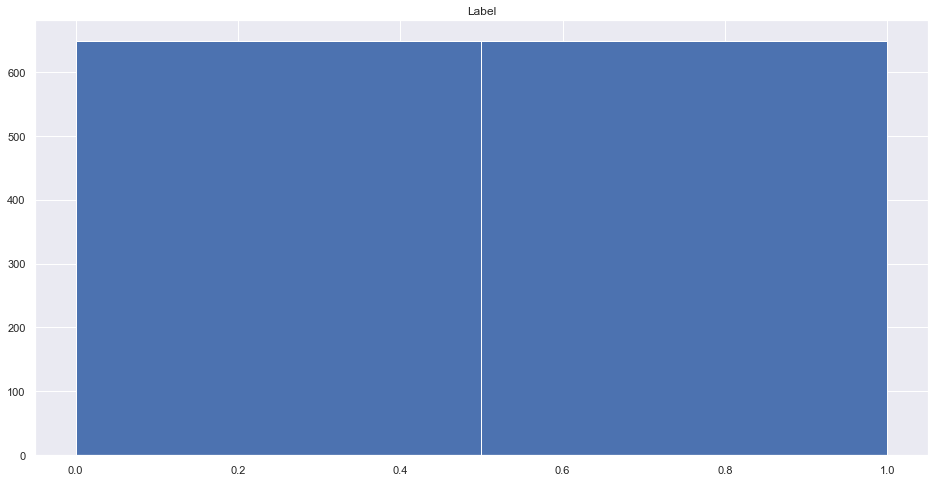

In [5]:
#Label distribution
hist = labels.hist(column='Label',bins=2)

Lets make a function that gets the filepath and image information as an array for a selected sensor based on the ID in the data frame.

In [6]:
def get_path_and_image_name(df, Image_ID):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    #img = cv.imread('filepath',0)
    img=Image.open(file_path)
    #img = resize(img, (1750, 1750), anti_aliasing=True)
    return np.array(img)


In [7]:
def get_path_and_image_name_resized(df, Image_ID, size):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    #img = cv.imread('filepath',0)
    img = imread(file_path)
    img = resize(img, (size, size), anti_aliasing=True)
    return np.array(img)


In [8]:
def get_file_path(df, Image_ID):
    filename = df.iloc[Image_ID, 0]
    path = df.iloc[Image_ID, 1]
    file_path = os.path.join(path, filename)
    return file_path

Lets take a look of a discarded sensor. see the intensity change in the dispensed layer - that means it is collapsed.

<Figure size 1080x792 with 0 Axes>

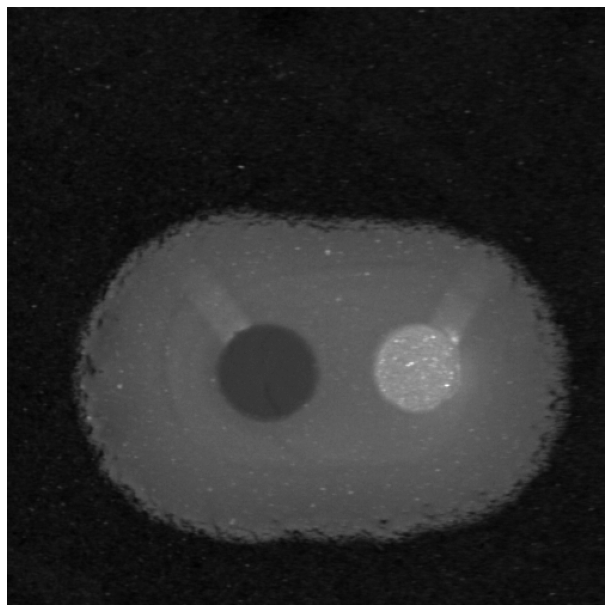

In [9]:
#A image of one of the discarded sensors
plt.figure(figsize=(15, 11))
temp = 6*200
image = imread(get_file_path(labels,temp), as_gray=True)
#4, 153, 37, 11, 12, 110, 129, 9, 36, 40, 42, 65, 0
# print('image shape before',image.shape)
# plt.imshow(image, cmap='gray')
# plt.title("a discarded sensor")
# plt.axis('off')
# plt.show()

image = resize(image, (500, 500), anti_aliasing=True)


plt.figure(figsize=(15, 11))
plt.imshow(image, cmap='gray')
#plt.title("Approved sensor, silicone")
plt.axis('off')
#plt.savefig('IMG_test')
plt.show()





#image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4),
#                       anti_aliasing=True)

In [10]:
image = imread(get_file_path(labels, 1), as_gray=True)
image = resize(image, (500, 500), anti_aliasing=True)
image.shape
imsave ('TEST_TEST.png', image)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


But one image is not representive - for each sensor, we have 6 images, a RGB-image with coxial lighting and a RGB-image for darkfield lighting. The images comes in 6 stand a 

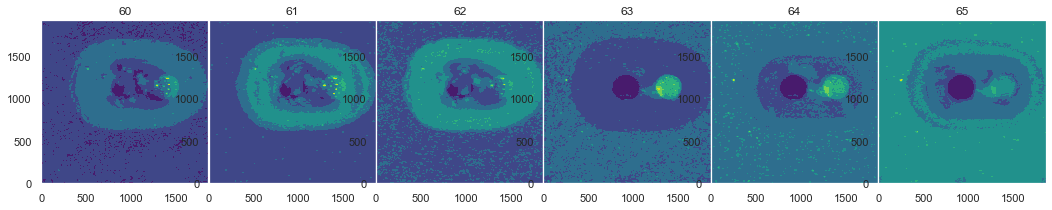

In [11]:
# with heatmap
plt.rcParams["image.cmap"] = 'viridis'

#fig, axs = plt.subplots(1,6, figsize=(18, 3), facecolor='w', edgecolor='k')
fig, axs = plt.subplots(1,6, figsize=(18, 3))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(6):

    axs[i].contourf(get_path_and_image_name(labels, 60+i))
    axs[i].set_title(str(60+i))

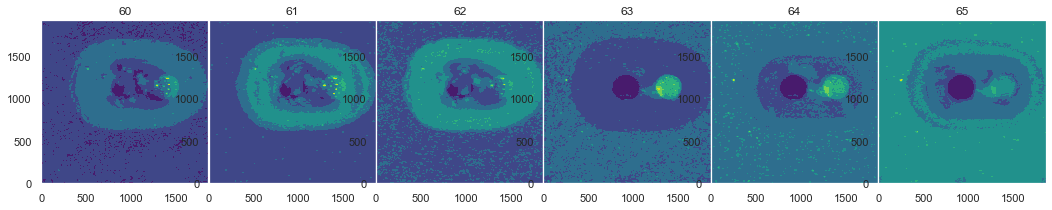

In [12]:
#Heatmap of a good sensor
fig, axs = plt.subplots(1,6, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(6):

    axs[i].contourf(get_path_and_image_name(labels, 60+i))
    axs[i].set_title(str(60+i))

# Test section - cropping of images

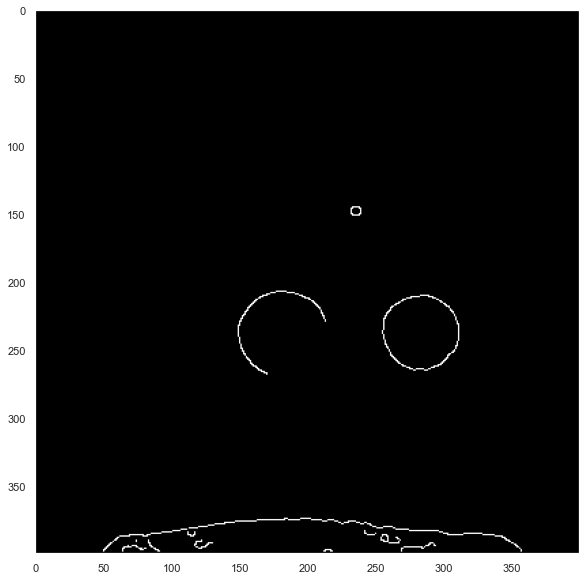

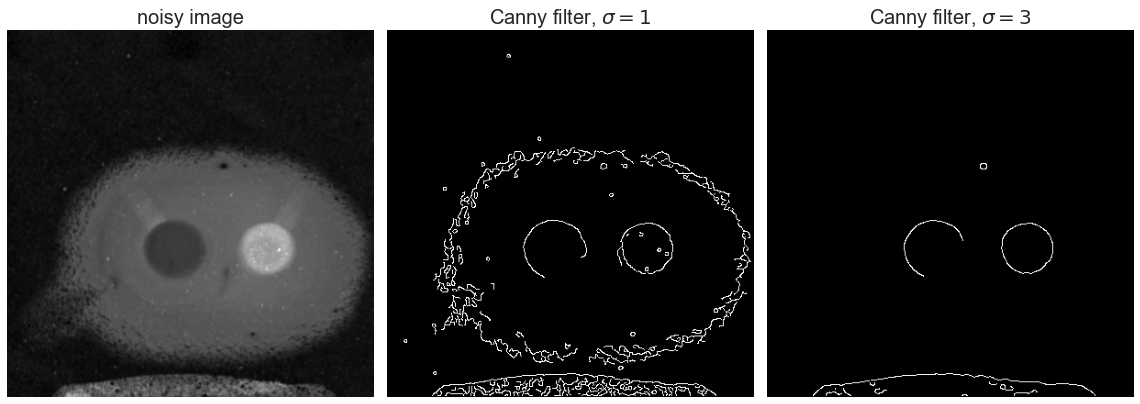

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

#im = ndi.rotate(im, 15, mode='constant')

image = get_path_and_image_name(labels, 300)
#im = imread(get_path_and_image_name(labels, 50), as_gray=True)
im = resize(image, (400, 400), anti_aliasing=True)
# im = imread(get_file_path(labels, 50), as_gray=True)
# im = resize(image, (1250, 1250), anti_aliasing=True)
im = ndi.gaussian_filter(im, 0.5)
#im += 0.5 * np.random.random(im.shape)



#Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=2)

hough_radii = np.arange(20, 35, 2)
hough_res = hough_circle(edges2, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1)

#Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18, 10))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(edges2, cmap=plt.cm.gray)
plt.show()

#display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

thresh 0.24340691061580796


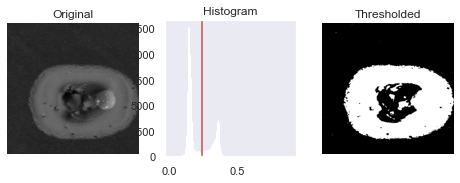

In [14]:
image = get_path_and_image_name(labels, 60)
image = resize(image, (400, 400), anti_aliasing=True)

thresh = threshold_otsu(image)
print('thresh', thresh)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')
plt.show()


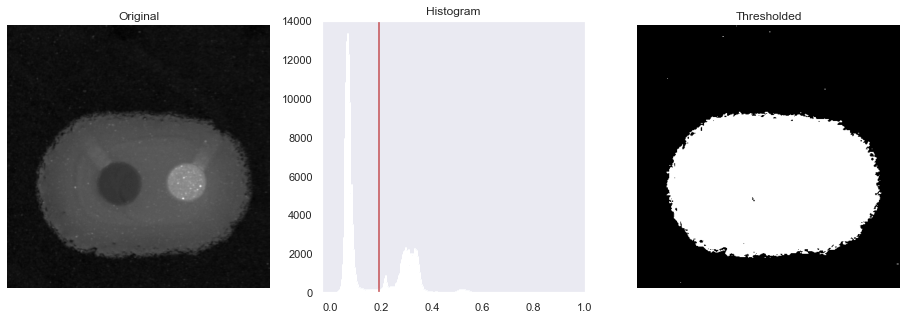

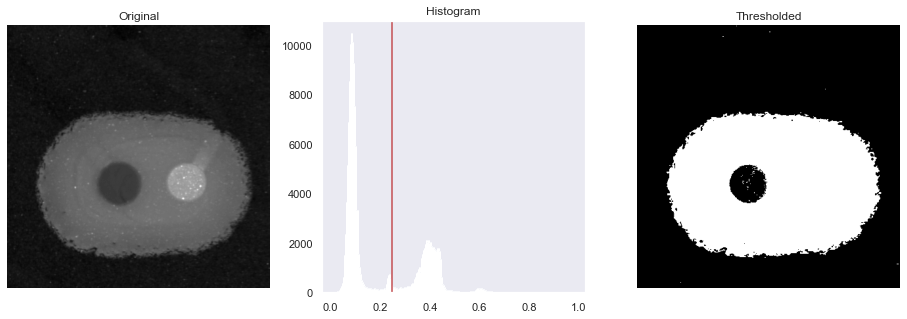

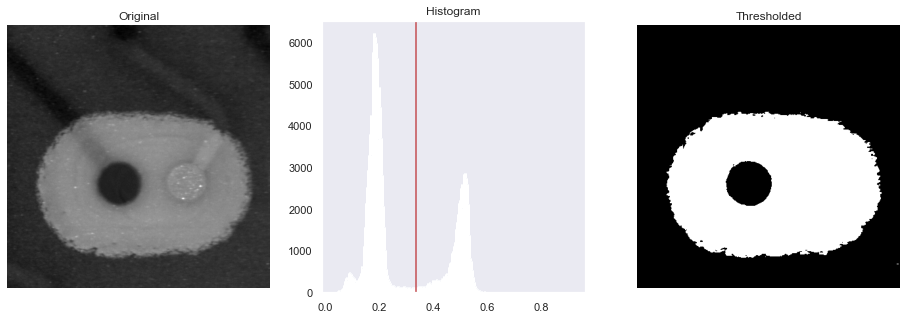

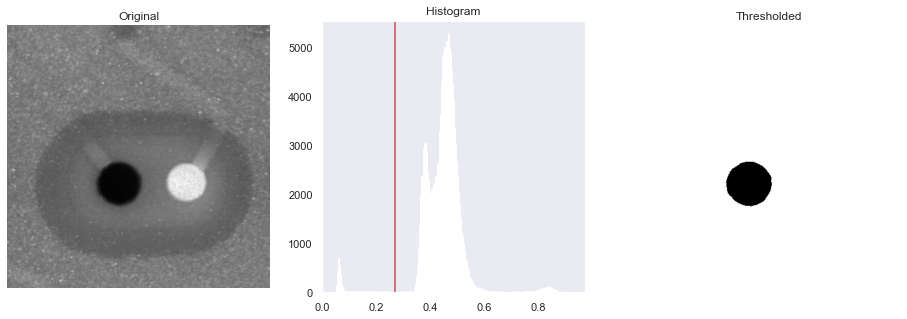

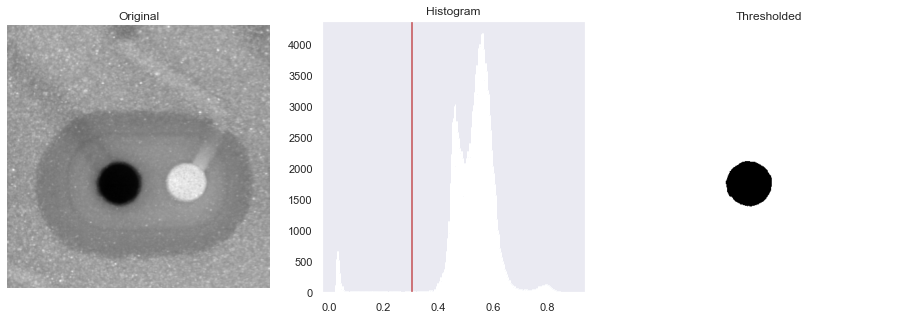

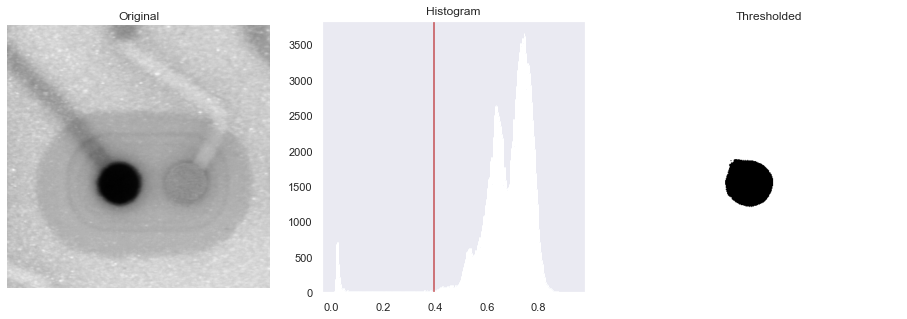

In [15]:
for img_id in range(6):
    image = get_path_and_image_name(labels, (900)+img_id) #300 - tush marker, #54 - total smushed sensor,
    image = resize(image, (400, 400), anti_aliasing=True)

    thresh = threshold_otsu(image)
    binary = image > thresh

    fig, axes = plt.subplots(ncols=3, nrows=6, figsize=(16, 5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(binary, cmap=plt.cm.gray)
    ax[2].set_title('Thresholded')
    ax[2].axis('off')
    plt.show()


In [16]:
def crop_image(img_id, tol=0): # not used
    
    image = get_path_and_image_name(labels, img_id)
    #image = resize(image, (400, 400), anti_aliasing=True)

    thresh = threshold_otsu(image)
    binary = image > thresh
    # img is 2D image data
    # tol  is tolerance
    mask = binary>tol
    #print('mask', mask)
    return image[np.ix_(mask.any(1),mask.any(0))]
    #return mask

In [17]:
def get_crop_mask(img_id, tol=0):
    
    image = get_path_and_image_name(labels, img_id)
    #image = resize(image, (400, 400), anti_aliasing=True)

    thresh = threshold_otsu(image)
    binary = image > thresh
    # img is 2D image data
    # tol  is tolerance
    mask = binary>tol
    #print('mask1', mask)
    #return image[np.ix_(mask.any(1),mask.any(0))]
    return mask

In [18]:
def crop_image2(img_id, Mask, tol=0):
    
    image = get_path_and_image_name(labels, img_id)
    mask = Mask
    #print('mask2', mask)
    return image[np.ix_(mask.any(1),mask.any(0))]
    #return mask

In [19]:
def get_shape_in_mm(image):
    res = 0.0021
    print('width:', image.shape[0]*res, 'mm')
    print('length:', image.shape[1]*res, 'mm')

(1091, 1579)
width: 2.2910999999999997 mm
length: 3.3158999999999996 mm


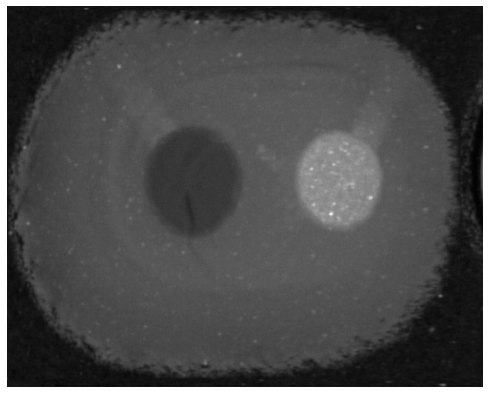

In [32]:
temp = 110*6
base_img = temp
mask = get_crop_mask(temp+2)
#print('mask3', mask)
image = crop_image2(base_img, mask)
print(image.shape)
get_shape_in_mm(image)
image = resize(image, (400, 500), anti_aliasing=True)
plt.figure(figsize=(10, 7))
plt.imshow(image, cmap='gray')
#plt.title("a discarded sensor")
plt.axis('off')
plt.savefig('cropped_sensor')
plt.show()



# Feature extraction

mask3 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


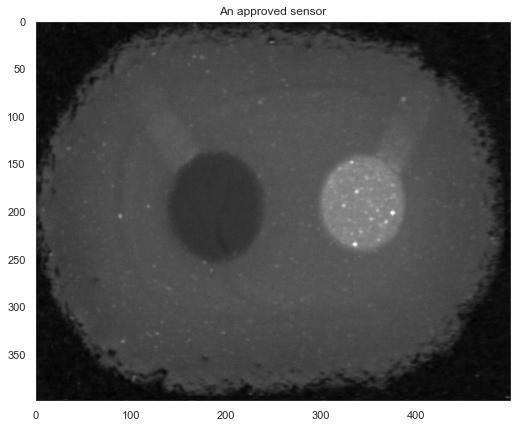

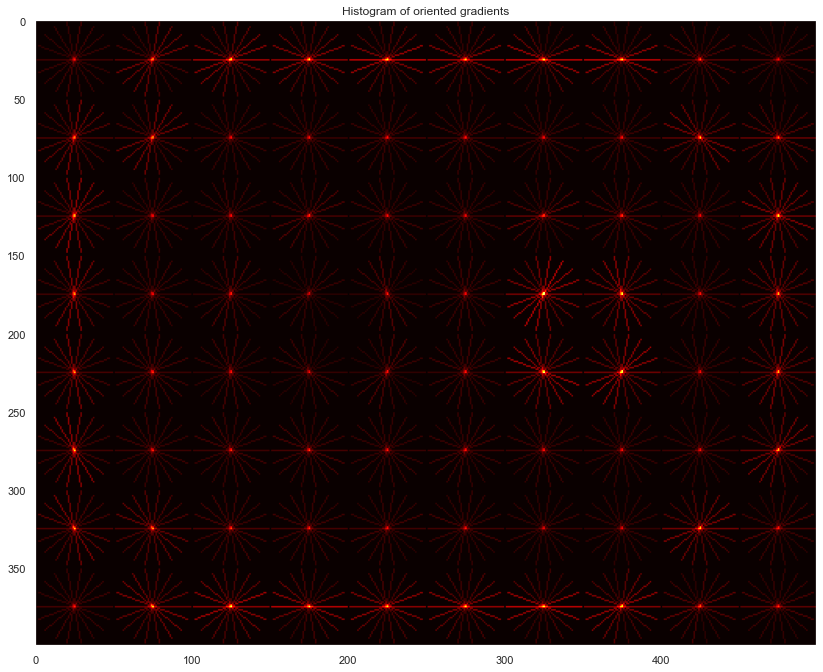

In [571]:
#TEST
mask = get_crop_mask(902)
print('mask3', mask)
image = crop_image2(900, mask)

#image = get_path_and_image_name(labels, 66)

image = resize(image, (400, 500), anti_aliasing=True)
plt.figure(figsize=(10, 7))
plt.imshow(image, cmap='gray')
plt.title("An approved sensor")
# ax.set_xticks(np.arange(0, 500, 50))
# ax.set_yticks(np.arange(0, 400, 50))
# ax.set_xticklabels(np.arange(0, 500, 50))
# ax.set_yticklabels(np.arange(0, 400, 50))
plt.show()

plt.rcParams['figure.figsize'] = (14, 14)
#hog_features, hog_image = hog(get_path_and_image_name_resized(labels,300, 400),
hog_features, hog_image = hog(image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(50, 50)) #originally 500, 100 x 84 

plt.imshow(hog_image, cmap=mpl.cm.hot)
plt.title("Histogram of oriented gradients")

ax = plt.gca();
# ax.set_xticks(np.arange(0, 500, 50));
# ax.set_yticks(np.arange(0, 400, 50));
# ax.set_xticklabels(np.arange(0, 500, 50));
# ax.set_yticklabels(np.arange(0, 400, 50));
#ax.grid(color='w', linestyle='--', linewidth=0.5)
plt.rcParams["axes.grid"] = False


In [572]:
#Test
plt.rcParams['figure.figsize'] = (15, 15)
test = hog(get_path_and_image_name(labels,300),
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(500, 500)) #originally 500, 100x84
print('type test', type(test))
print('test:', test)

type test <class 'tuple'>
test: (array([0.15676735, 0.09678463, 0.12242987, 0.06887085, 0.09802711,
       0.06324265, 0.09998278, 0.07813186, 0.05558478, 0.14110374,
       0.08622281, 0.11986942, 0.07017681, 0.09957776, 0.06401793,
       0.10081709, 0.07194534, 0.0484627 , 0.13432938, 0.08083774,
       0.12091141, 0.07100264, 0.1024359 , 0.06428587, 0.09765181,
       0.06559142, 0.04524328, 0.16973972, 0.10945898, 0.12696442,
       0.07339353, 0.09856102, 0.06450248, 0.10723087, 0.08943232,
       0.06583176, 0.1624038 , 0.11886045, 0.15116141, 0.09662503,
       0.12326283, 0.08705993, 0.12042679, 0.09590268, 0.06713245,
       0.15089242, 0.10596407, 0.14186041, 0.0966593 , 0.12807157,
       0.08973281, 0.12321081, 0.09118351, 0.06317247, 0.18947476,
       0.13272837, 0.14158935, 0.0852483 , 0.10704812, 0.07937039,
       0.12599154, 0.11551568, 0.08406983, 0.16244422, 0.11340215,
       0.14851572, 0.09489854, 0.12532672, 0.08965565, 0.12530974,
       0.09598897, 0.0697678 

lets make a function that generate the HOG-features for all images in our dataset. since each sensor consist of 6 images, we will stack the images so one sensor is represented in the feature space by all 6 images

In [573]:
def create_feature_matrix_stacked(label_df,hog_size):
    
    features_list = []
    image_features_stacked = []
    for img_id in label_df.index: #Iterate over DataFrame
        #print('img_id',img_id)
        
        if label_df.iloc[img_id,2] == 1: #if this is the first band, proceed
            root_image = img_id #define root image
            image_features_stacked = [] # create/reset list
            
            #Generate cropping mask, extracted from the third band(emperic tested)
            mask = get_crop_mask(root_image + 2)
    
            
            print('Root image:', root_image) #just to keep track while running
            for band in range(6): #Iteration over bands
                image = crop_image2(img_id, mask)
                image = resize(image, (400, 500), anti_aliasing=True)
                
                #print('band:', band)
                image_features =  hog(image, block_norm='L2-Hys', pixels_per_cell=(hog_size, hog_size)) #Generate image features
                image_features_stacked = np.hstack((image_features_stacked, image_features))

                #stack images
                if band == 5: # stack the image features when the all bands has been processed
                    features_list.append(image_features_stacked)
                    #print('shape of features list', len(features_list))
                    
                
     # convert list of arrays into a matrix
    features_matrix = np.array(features_list)               
                    
    return features_matrix
    


This a pretty time comsuming task, so while we are at it, lets make sure we only extract features if it is necesarry, i.e don't want to do it twice. Lets save the features in a file and only make a new if we do not already have a file with that name

In [574]:
def load_or_generate_hog(labels, hog_size, load=False):
    name = 'feature_matrix_stacked_Si_smote_hog_' + str(hog_size) +'.csv'
    print(name)
    if load == True:
        temp = np.asarray(pd.read_csv(name, header=None))
        temp = pd.DataFrame(temp)
        print('File loaded as:', name)
        
    else:
        temp = create_feature_matrix_stacked(labels, hog_size)
        #np.savetxt(name, temp, delimiter=",")
        pd.DataFrame(temp)
        print('SAVE IS DISABLED: File saved as:', name)
    return temp
        

In [575]:
# #Call the function
#feature_matrix = create_feature_matrix_stacked(labels, 100)
feature_matrix = load_or_generate_hog(labels,50, load=False)

feature_matrix_stacked_Si_smote_hog_50.csv
Root image: 0
Root image: 6
Root image: 12
Root image: 18
Root image: 24
Root image: 30
Root image: 36
Root image: 42
Root image: 48
Root image: 54
Root image: 60
Root image: 66
Root image: 72
Root image: 78
Root image: 84
Root image: 90
Root image: 96
Root image: 102
Root image: 108
Root image: 114
Root image: 120
Root image: 126
Root image: 132
Root image: 138
Root image: 144
Root image: 150
Root image: 156
Root image: 162
Root image: 168
Root image: 174
Root image: 180
Root image: 186
Root image: 192
Root image: 198
Root image: 204
Root image: 210
Root image: 216
Root image: 222
Root image: 228
Root image: 234
Root image: 240
Root image: 246
Root image: 252
Root image: 258
Root image: 264
Root image: 270
Root image: 276
Root image: 282
Root image: 288
Root image: 294
Root image: 300
Root image: 306
Root image: 312
Root image: 318
Root image: 324
Root image: 330
Root image: 336
Root image: 342
Root image: 348
Root image: 354
Root image: 360


we got tha data as an np.array, lets convert it to a pd.dataframe and while were at it, lets take a look on the dimensions.

In [576]:
#Get the dimensions of the data frame
feature_matrix_df = pd.DataFrame(feature_matrix)
dims=feature_matrix_df.shape
# feature_matrix.shape
# print('rows in DF', dims[0])
# print('columns in DF', dims[1])
#feature_matrix_df = pd.DataFrame(list(feature_matrix))
feature_matrix_df.head()
#print('shape', feature_matrix_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,23318,23319,23320,23321,23322,23323,23324,23325,23326,23327
0,0.105780,0.080213,0.077303,0.064074,0.085543,0.072038,0.067860,0.065281,0.102151,0.092654,...,0.080942,0.085262,0.077685,0.088152,0.080792,0.085961,0.077206,0.063055,0.070845,0.070437
1,0.131277,0.101317,0.075000,0.071839,0.084149,0.063238,0.059488,0.087186,0.104605,0.119486,...,0.069844,0.100394,0.077371,0.077859,0.075765,0.093423,0.076402,0.074461,0.079068,0.081751
2,0.146679,0.101142,0.079770,0.081638,0.110425,0.079312,0.081671,0.089215,0.124262,0.117248,...,0.076960,0.105641,0.091995,0.087916,0.091444,0.126285,0.095935,0.091257,0.095471,0.088401
3,0.102567,0.072260,0.068538,0.072948,0.088808,0.075274,0.065807,0.082152,0.084120,0.107188,...,0.075138,0.099162,0.073569,0.085902,0.097013,0.101835,0.085291,0.082425,0.080933,0.088528
4,0.113396,0.095868,0.075078,0.069115,0.095531,0.088604,0.076461,0.095399,0.103907,0.128777,...,0.097247,0.101656,0.080630,0.076238,0.086815,0.092105,0.101404,0.090742,0.080318,0.079884


In [577]:
print('shape', feature_matrix_df.shape)

shape (216, 23328)


# PCA

In [578]:
#Standardize feature matrix

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
FMS = ss.fit_transform(feature_matrix_df) #Feature Matrix Standardized
FMS = pd.DataFrame(FMS) 
FMS.head()


,0,1,2,3,4,5,6,7,8,9,...,23318,23319,23320,23321,23322,23323,23324,23325,23326,23327
0,-0.179948,-0.374514,-0.155798,-1.198346,-0.658640,-0.532259,-0.898329,-1.644648,0.276280,-0.998406,...,0.367413,0.227305,0.371457,0.562185,-0.711664,-1.077935,-0.861849,-1.442333,0.025370,0.158989
1,0.986466,1.575845,-0.389656,-0.656376,-0.712645,-1.094303,-1.687149,0.313056,0.396618,0.172459,...,-0.203002,1.119346,0.345328,-0.336344,-0.968747,-0.813359,-0.906745,-0.350784,0.745841,0.897992
2,1.691033,1.559630,0.094661,0.027597,0.305473,-0.067630,0.403111,0.494398,1.360587,0.074804,...,0.162739,1.428648,1.562378,0.541651,-0.166933,0.351862,0.184219,1.256668,2.183162,1.332405
3,-0.326929,-1.109507,-1.045717,-0.578950,-0.532112,-0.325544,-1.091780,-0.136825,-0.607882,-0.364164,...,0.069092,1.046717,0.028862,0.365797,0.117911,-0.515085,-0.410293,0.411390,0.909261,1.340656
4,0.168478,1.072190,-0.381710,-0.846455,-0.271629,0.525845,-0.087831,1.047148,0.362403,0.577895,...,1.205398,1.193734,0.616519,-0.477852,-0.403635,-0.860086,0.489726,1.207385,0.855371,0.776069


Lets take a look on the explained variance, to know just how much we should reduce the dimensionality 

cum_car_exp [ 14.34206103  22.66236272  30.60040067  35.39626056  39.25686288
  42.60600206  45.28356661  47.80496429  49.92519565  51.73665437
  53.47246629  55.066365    56.55533446  57.8155767   59.04146927
  60.22836913  61.27371598  62.23912529  63.12200893  63.98622296
  64.76231092  65.52494411  66.25499505  66.94007511  67.61476945
  68.26072435  68.88551187  69.49937964  70.10143555  70.67511076
  71.23549831  71.77786614  72.30333559  72.80907774  73.29624363
  73.77314613  74.24555629  74.69749036  75.13882942  75.57658694
  75.99325866  76.40387259  76.80265754  77.17987833  77.55374171
  77.91994747  78.27755305  78.63170375  78.97969645  79.32481645
  79.66083415  79.98944855  80.31453691  80.63355329  80.94825573
  81.25602284  81.55471922  81.84944427  82.13993279  82.42761998
  82.70348926  82.97654466  83.24625744  83.51315028  83.77898238
  84.03790308  84.28869539  84.53515855  84.77784244  85.01491911
  85.24860975  85.48107511  85.70695813  85.92908986  86.1503933

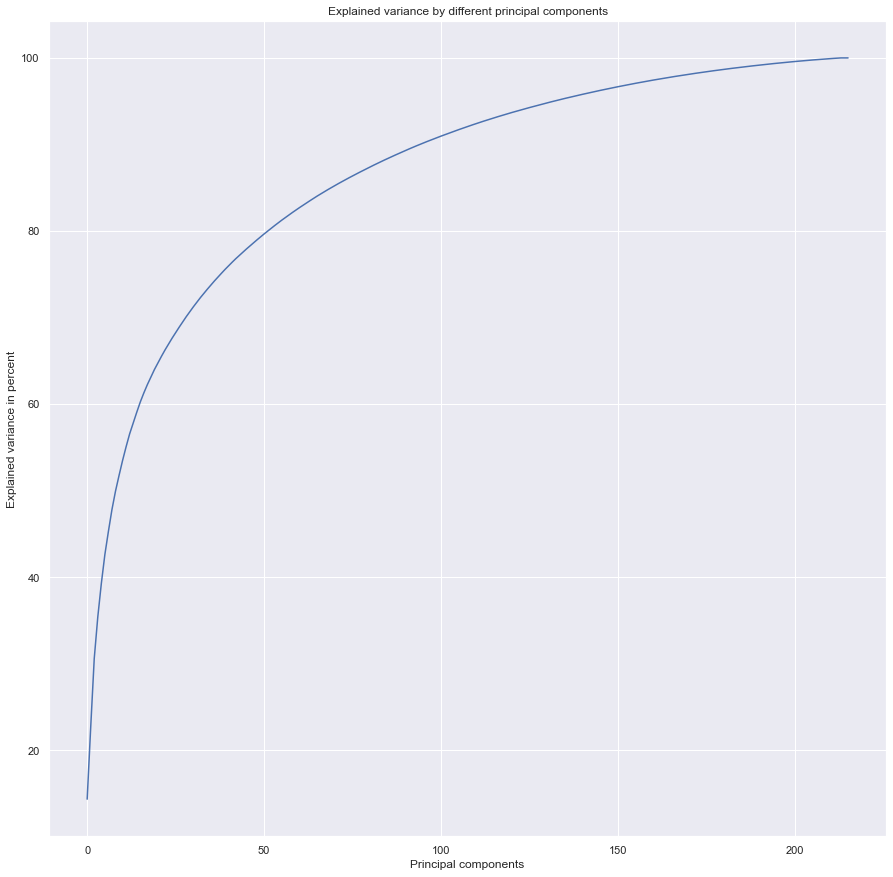

In [579]:
#Explained variance

FMS_pca = PCA() #Feature Matrix Standadized(FMS)_PCA
FMS_pca = FMS_pca.fit(FMS)

tot = sum(FMS_pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(FMS_pca.explained_variance_, reverse=True)]
pc_title=['PC %s' %i for i in range(1,dims[1])]

#for cname, val in zip(pc_title, var_exp):
    #print("%s = %.2f"%(cname, val))

cum_var_exp = np.cumsum(var_exp)
print('cum_car_exp',cum_var_exp)

plt.plot(cum_var_exp)
plt.title('Explained variance by different principal components')
plt.ylabel('Explained variance in percent')
plt.xlabel('Principal components')
plt.grid()
plt.show()

Now lets reduce the dimensionality, depending on the HOG_size used in the feature extraction the amount of components may differ. 

In [580]:
#PCA
#Lifehack: 6 components for HOG-size=500, 83 for HOG_size 100, 101 for HOG_size 50
n_pca_components = 216 #216
FMS_pca = PCA(n_components=(n_pca_components)) #Feature Matrix Standadized(FMS)_PCA
FMS_pca = FMS_pca.fit_transform(FMS)
FMS_pca = pd.DataFrame(FMS_pca)
print('shape of Feature Matrix standardized Principal Component Analasys', FMS_pca.shape)
#FMS_pca.head()

shape of Feature Matrix standardized Principal Component Analasys (216, 216)


# split & train

With all the feature extracted, the training can almost begin, but first it is needed to make labels that correspond to the stacked images

In [581]:
#making the labels_df that corresponds to the stacked images

labels_stacked = labels.set_index('Sensor_ID')
labels_stacked = labels_stacked[labels_stacked.Band == 1]
labels_stacked = labels_stacked.drop(["Old Name", "Path", "Band"], axis = 1)
labels_stacked.describe()
#print('shape', labels_stacked.shape)


,Label
count,216.000000
mean,0.500000
std,0.501161
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


Lets just double cheack that the index/shape matches

In [582]:
#X datasaet for classification - Features
X_class = FMS_pca
#X_class = FMS
X_class.shape


(216, 216)

In [583]:
# y dataset for classification - labels
y_class = pd.DataFrame(labels_stacked['Label'])
y_class.shape

(216, 1)

everything looks good, lets begin

False predicted sensor ID: [32, 65, 36, 37, 42, 59, 62, 88, 0, 10, 11, 66, 35, 96]
Total amount of misclassified sensors 15
-------Train score--------
Mean: 1.0
Std. Deviation: 0.0
--------Test score---------
Mean: 0.9350951374207188
Std. Deviation 0.047517472992787156


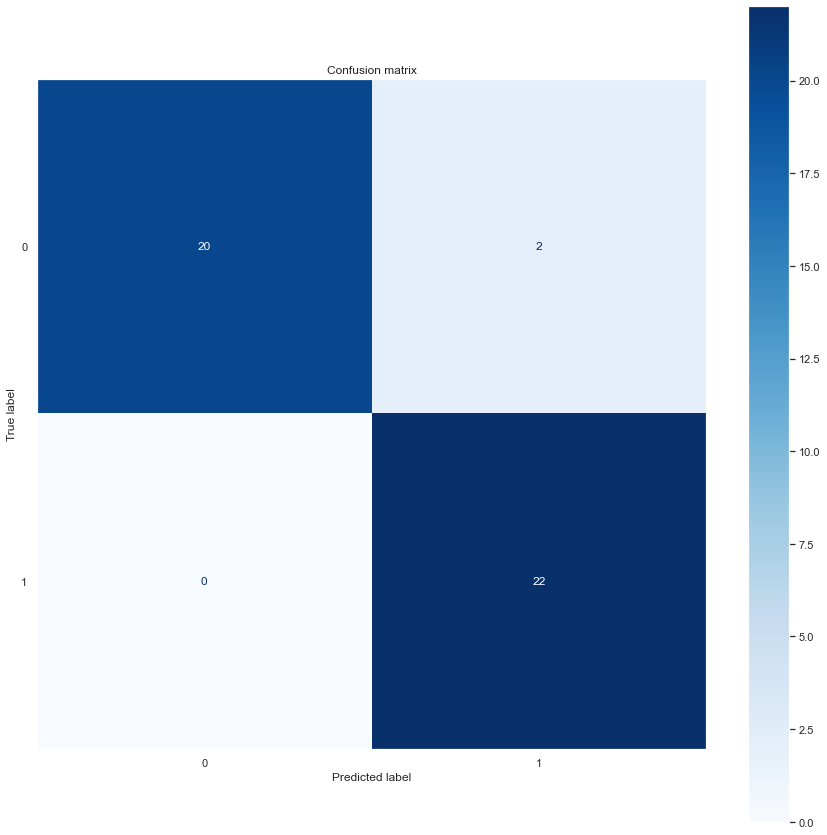

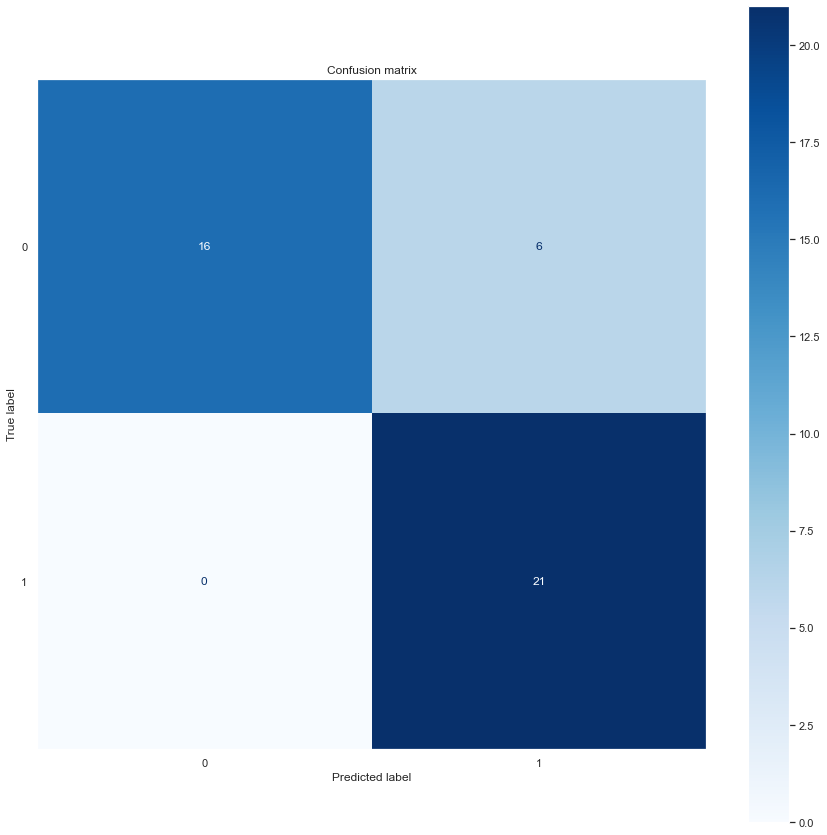

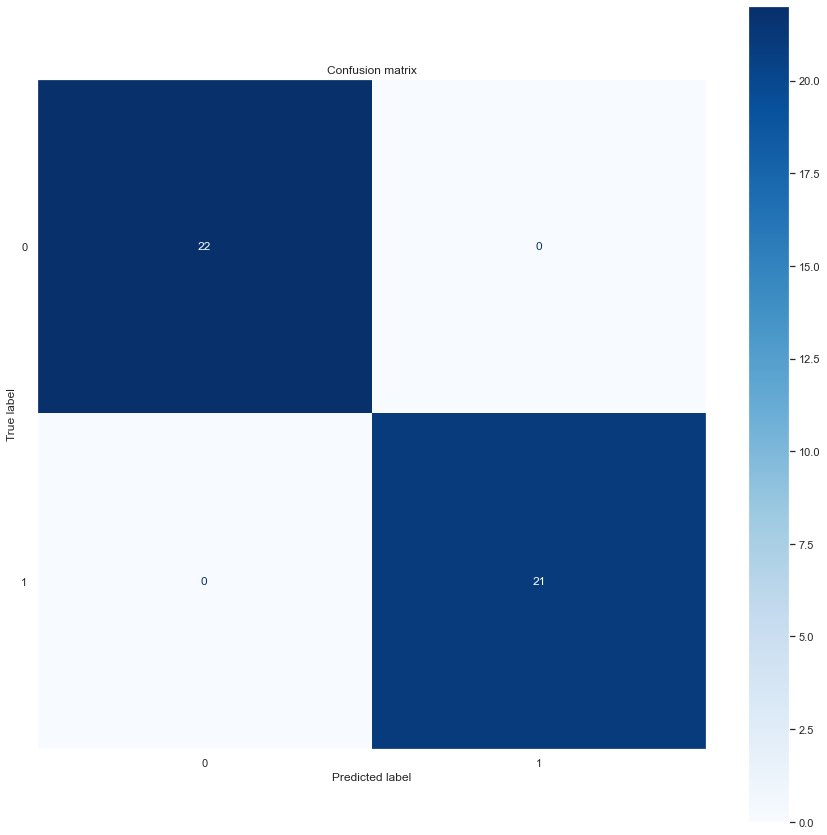

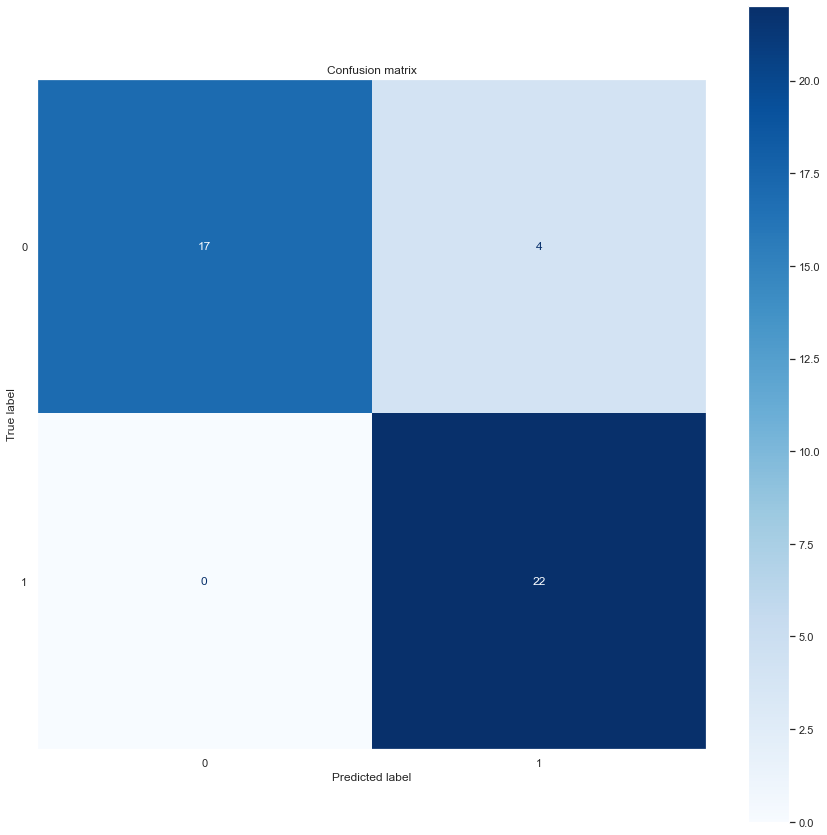

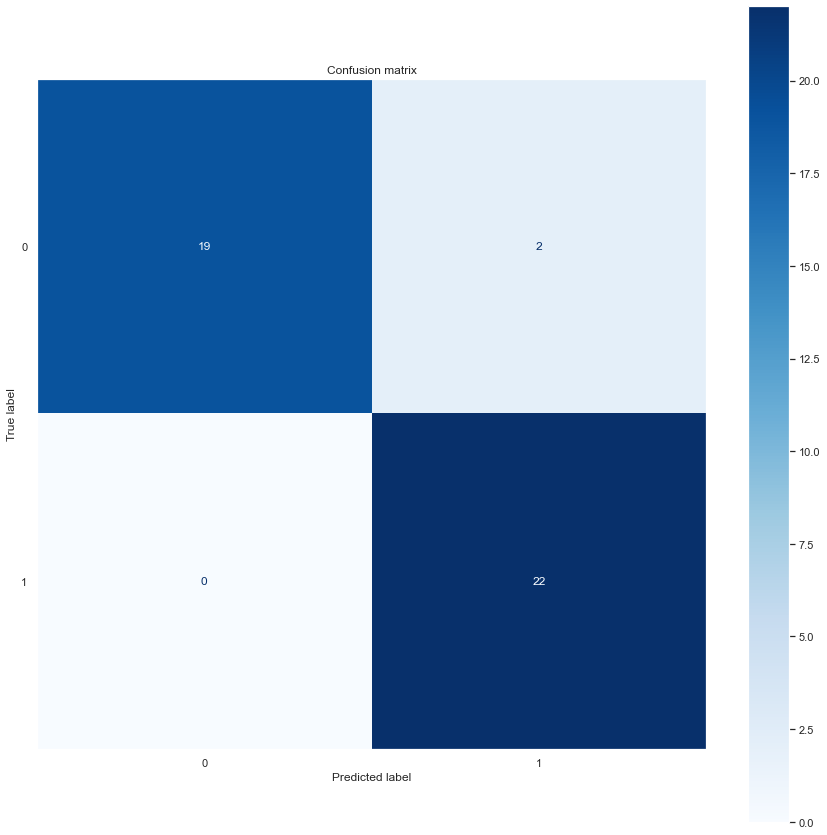

In [610]:
#-----Test model------ this is just for playing around

from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

#clfSVM = SVC(gamma='scale',kernel='linear')
train_score    = []
test_score     = []
accuracy_list = []
false_predicted = []
smote = False 

#Split the data
#kf = KFold(n_splits=5, random_state=42, shuffle=False)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_class, y_class):
    #-------Splitting-------------
    #print("TEST SET", test_index)
    if smote == True:
        sm = SMOTE(random_state = 42)
        
        X_train = X_class.iloc[train_index]
        print('x_train before', X_train.shape)
        X_test  = X_class.iloc[test_index]
        y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
        X_train, y_train = sm.fit_sample(X_train, y_train)
        print('X_train after',X_train.shape)
        print('------------')
        
        
    else:
        X_train = X_class.iloc[train_index]
        X_test  = X_class.iloc[test_index]
        y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
    
    #----------Training------------
    clfSVM = SVC(kernel='linear', decision_function_shape='ovr')
    clfSVM.fit(X_train, y_train)
    train_score.append(clfSVM.score(X_train, y_train))
    test_score.append(clfSVM.score(X_test, y_test))
    y_pred = clfSVM.predict(X_test)
    #print('----------')
    #print('y_pred:',y_pred)
    accuracy = (y_test, y_pred)
    accuracy_list.append(accuracy_score(y_test, y_pred))
    confusion_matrix(y_test, y_pred)
    
    
    # format date to lists
    y_test_temp = pd.DataFrame(y_test)
    y_test_temp = y_test_temp['Label'].tolist()
    y_pred_temp = y_pred.tolist()
    
    # find the sensors that have been falesely predicted
    for i in range (len(y_test_temp)-1):
        if y_test_temp[i] != y_pred_temp[i]:
            false_predicted.append(y_test.index.values.tolist()[i])
            

            
    


    
    
    #local cinfusion matrix
    confusion_matrix(y_test, y_pred)
    disp = plot_confusion_matrix(clfSVM, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize= None)
    disp.ax_.set_title('Confusion matrix')

#     print('Confusion matrix')
#     print(disp.confusion_matrix)

    
mean_test  = np.mean(test_score)
std_test   = np.std(test_score)

mean_train = np.mean(train_score)
std_train  = np.std(train_score)

print('False predicted sensor ID:', false_predicted)
print('Total amount of misclassified sensors', len(false_predicted)+1)

# mean_acc   = np.mean(accuracy_list)
# std_acc    = np.std(accuracy_list)

print('-------Train score--------')
print('Mean:', mean_train)
print('Std. Deviation:', std_train)
print('--------Test score---------')
print('Mean:', mean_test)
print('Std. Deviation', std_test)

# SVM

In [585]:
#-------KFold classification function ---------------

from sklearn.svm import SVC
import warnings
#warnings.filterwarnings("ignore")
# train_score = []
# test_score  = []

def SVM_kfold(C_reg, Kernel, kfolds, X_class, y_class):

    #Define classifier and KFolds
    #Kfold
    #kf = KFold(n_splits=kfolds, random_state=42, shuffle=True)
    #Stratified Kfold
    kf = StratifiedKFold(kfolds, shuffle=True, random_state=42)
    train_score_svm = []
    test_score_svm  = []
    for train_index, test_index in kf.split(X_class, y_class):
    #-------Define Classifier---------
        clf_SVM1 = 0 # reset
        clf_SVM1 = SVC(gamma='scale', kernel=Kernel, C=C_reg)
        
    #-------Splitting-------------
    #print("TEST SET", test_index)
        X_train = X_class.iloc[train_index]
        X_test  = X_class.iloc[test_index]
        y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
    
    #----------Training/Testing------------
        clf_SVM1.fit(X_train, y_train)
        train_score_svm.append(clf_SVM1.score(X_train, y_train))
        test_score_svm.append(clf_SVM1.score(X_test, y_test))
        y_pred = clf_SVM1.predict(X_test)
        confusion_matrix(y_test, y_pred)
#         print('Casper used confusion, it was very effective:::')
#         print(confusion_matrix(y_test, y_pred))
    
    #Calculating mean and std.dev
    mean_test_svm  = np.mean(test_score_svm)
    std_test_svm   = np.std(test_score_svm)

    mean_train_svm = np.mean(train_score_svm)
    std_train_svm  = np.std(train_score_svm)


#     print('-------Train score---------')
#     print('Mean:', mean_train_svm)
#     print('Std. Deviation:', std_train_svm)
#     print('--------Test score---------')
#     print('Mean:', mean_test_svm)
#     print('Std. Deviation', std_test_svm)
    return mean_test_svm, std_test_svm, mean_train_svm, std_train_svm

print('----------------Baseline------------------------')
SVM_kfold(1*0.00008,'linear', 5, X_class, y_class)
#print('-----------------Without PCA--------------------')
#SVM_kfold('rbf', 10, feature_matrix_df, X_class, y_class) 

----------------Baseline------------------------


(0.9258985200845666,
 0.04005268533501764,
 0.9919007931173545,
 0.004620935120764331)

In [586]:
# regulization_mean_train_list = []
# regulization_std_train_list  = []
# regulization_mean_test_list = []
# regulization_std_test_list  = []
# x_axis = []

# for n in range(1, 1000, 1): #999    
#     c=1/(n*0.0000001)
#     SVM = SVM_kfold(n*0.0000001,'linear', 5, X_class, y_class)
#     regulization_mean_train_list.append(SVM[2])
#     regulization_std_train_list.append(SVM[3])
#     regulization_mean_test_list.append(SVM[0])
#     regulization_std_test_list.append(SVM[1])
#     x_axis.append(n*0.0000001)    

In [587]:
# plt.title('performance')
# ax = sns.lineplot(x_axis, regulization_mean_test_list, ci=regulization_std_test_list, label='Test set')
# ax = sns.lineplot(x_axis, regulization_mean_train_list, ci=regulization_std_train_list, label='Train set')



### Copy paste from Baseline vs without PCA:
from hog_size = 100
----------------Baseline------------------------ 

-------Train score---------

Mean: 0.831060606060606

Std. Deviation: 0.06374899844367098

--------Test score---------

Mean: 0.9651648739199435

Std. Deviation 0.004279085749226928

-----------------Without PCA--------------------

-------Train score---------

Mean: 0.8094696969696968

Std. Deviation: 0.07877604077732622

--------Test score---------

Mean: 0.906771292540998

Std. Deviation 0.05958013581685448


# Nearest centroid

In [588]:
#-------Nearest centroid ---------------

from sklearn.neighbors import NearestCentroid
import warnings
#warnings.filterwarnings("ignore")
# train_score = []
# test_score  = []

def NCC_kfold(kfolds, X_class, y_class):

    #Define classifier and KFolds
    #----------Kfold
    kf = KFold(n_splits=kfolds, random_state=10, shuffle=True)

    train_score_NC = []
    test_score_NC  = []
    for train_index, test_index in kf.split(X_class, y_class): #Iteration over Kfolds
    #-------Define Classifier---------
        clf = 0 # reset
        clf = NearestCentroid()
        
    #-------Splitting-------------
    #print("TEST SET", test_index)
        X_train = X_class.iloc[train_index]
        X_test  = X_class.iloc[test_index]
        y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
    
    #----------Training/Testing------------
        clf.fit(X_train, y_train)
        train_score_NC.append(clf.score(X_train, y_train))
        test_score_NC.append(clf.score(X_test, y_test))
        y_pred = clf.predict(X_test)
        print('Casper used confusion, it was very effective:::')
        print(confusion_matrix(y_test, y_pred))

    
    #Calculating mean and std.dev
    mean_test_NC  = np.mean(test_score_NC)
    std_test_NC   = np.std(test_score_NC)

    mean_train_NC = np.mean(train_score_NC)
    std_train_NC  = np.std(train_score_NC)

    print('-------Train score---------')
    print('Mean:', mean_train_NC)
    print('Std. Deviation:', std_train_NC)
    print('--------Test score---------')
    print('Mean:', mean_test_NC)
    print('Std. Deviation', std_test_NC)
    #return train_score, test_score

print('----------------Baseline------------------------')
clf_NCC = NCC_kfold(5, X_class, y_class)
#print('-----------------Without PCA--------------------')
#SVM_kfold('rbf', 10, feature_matrix_df, y_class) 

----------------Baseline------------------------
Casper used confusion, it was very effective:::
[[21  1]
 [ 1 21]]
Casper used confusion, it was very effective:::
[[18  3]
 [ 4 18]]
Casper used confusion, it was very effective:::
[[19  4]
 [ 3 17]]
Casper used confusion, it was very effective:::
[[14  4]
 [ 2 23]]
Casper used confusion, it was very effective:::
[[13 11]
 [ 1 18]]
-------Train score---------
Mean: 0.8552964108079044
Std. Deviation: 0.014478950568650657
--------Test score---------
Mean: 0.8420718816067655
Std. Deviation 0.07444622781586337


# Regression

----------------Baseline------------------------
-------Train score---------
Mean: 1.0
Std. Deviation: 0.0
--------Test score---------
Mean: 0.9258985200845664
Std. Deviation 0.04513185026848943


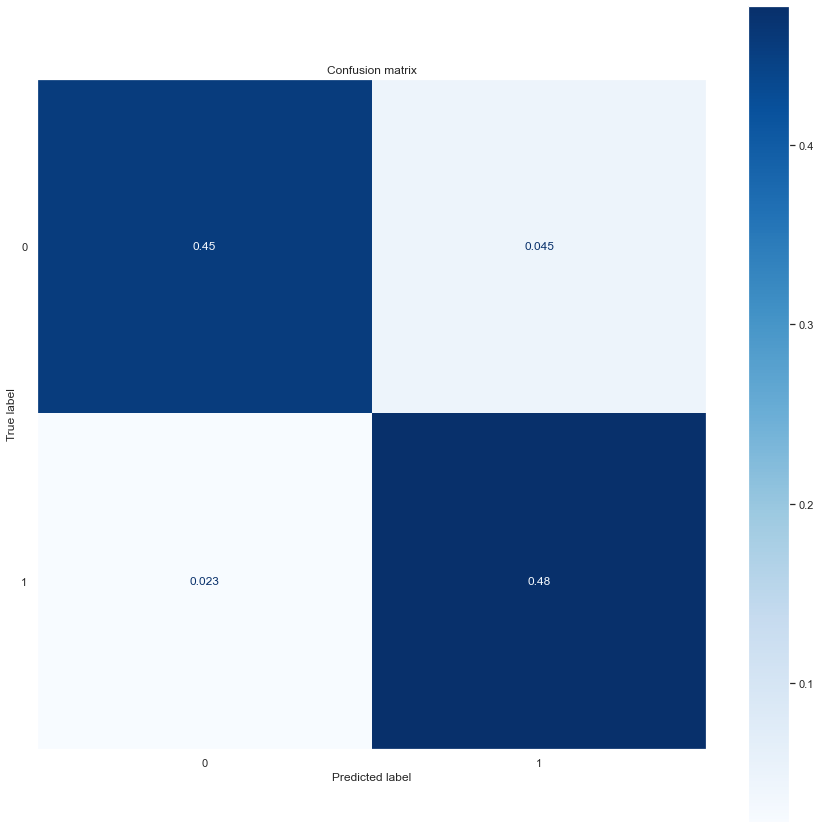

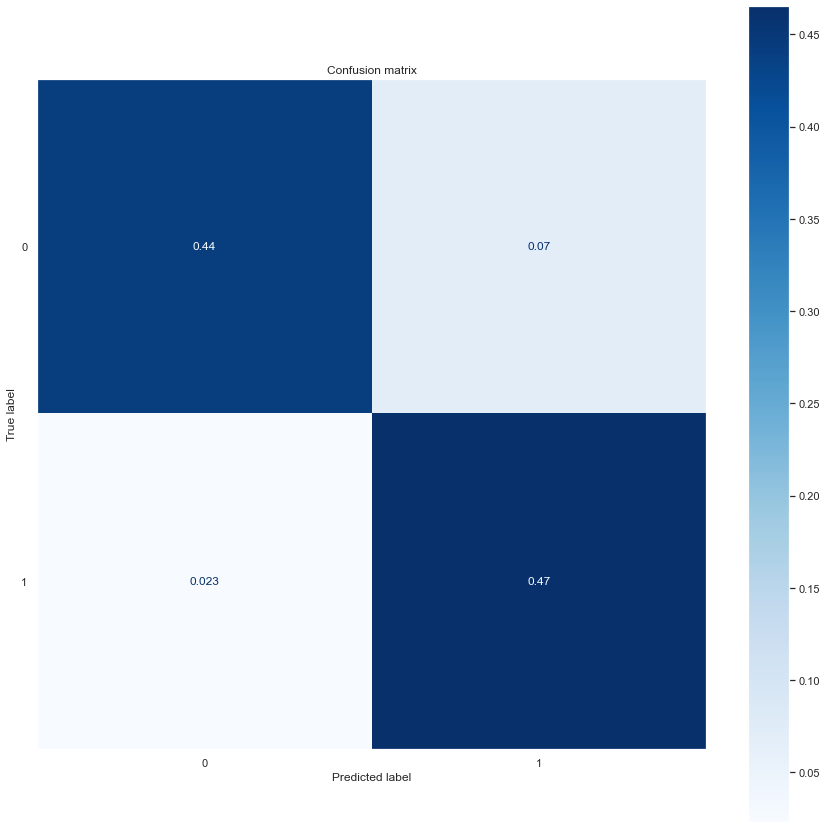

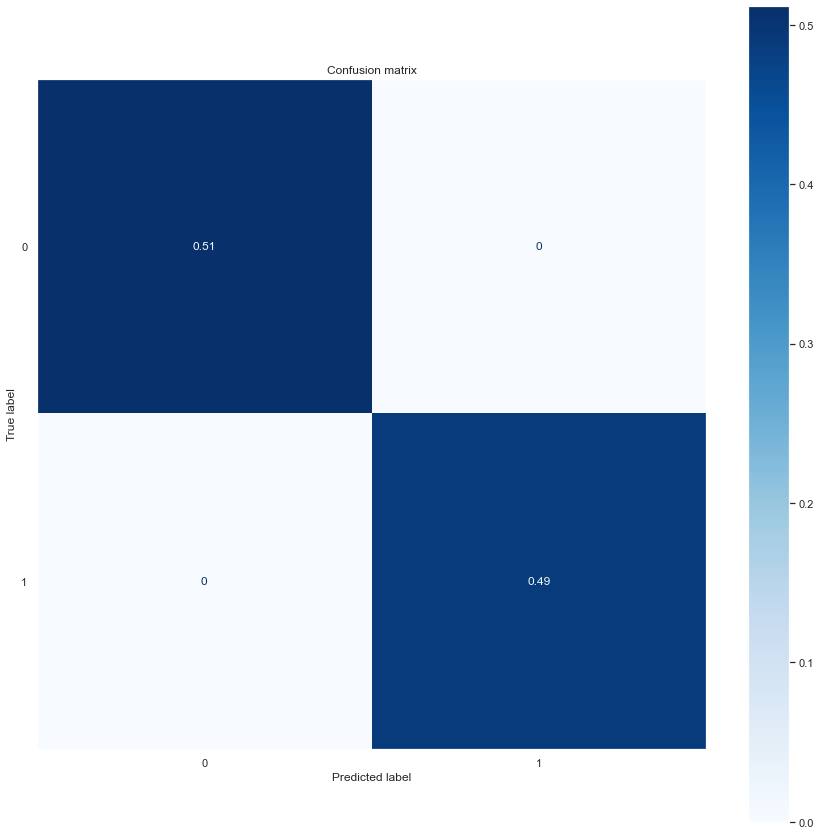

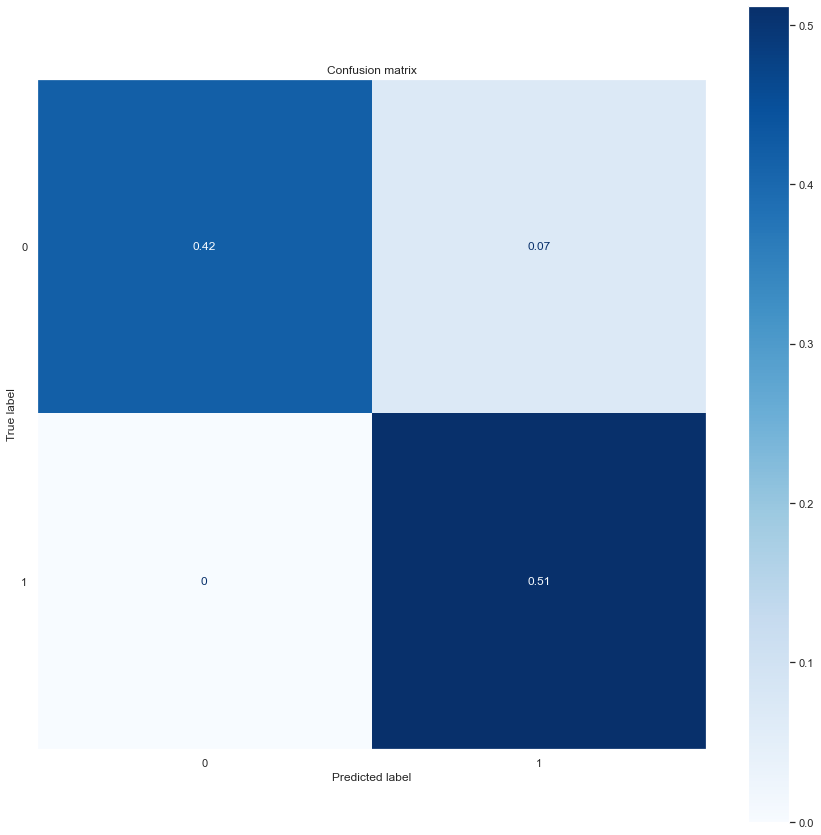

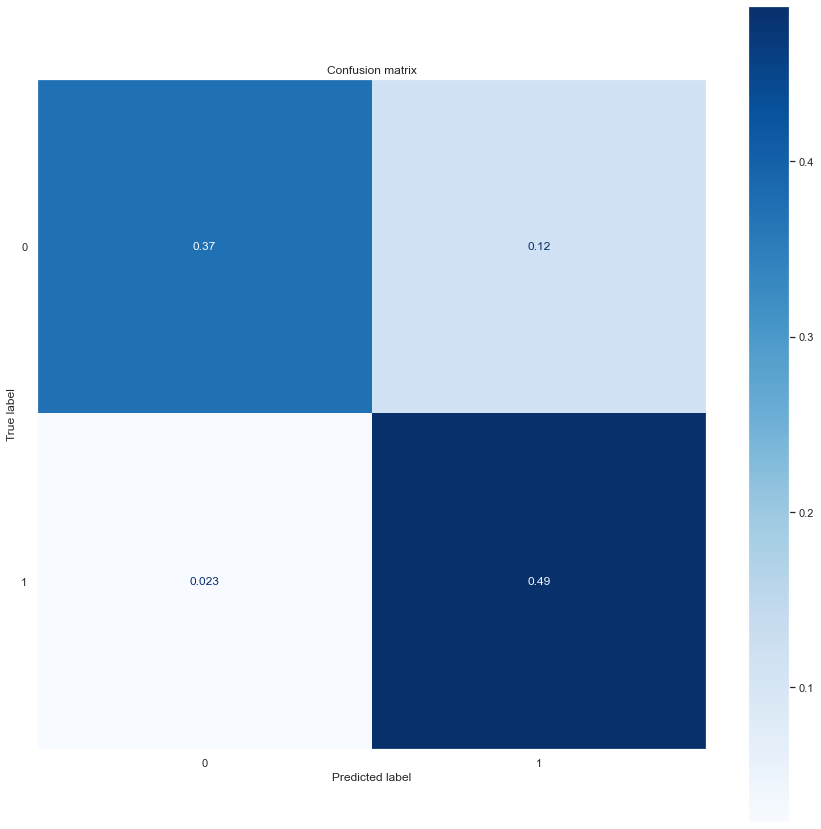

In [589]:
#-------regresssion classification function ---------------
from sklearn.linear_model import LogisticRegression
import warnings
#warnings.filterwarnings("ignore")
# train_score = []
# test_score  = []
smote = False

def regressor_kfold(SOLVER, PENALTY, kfolds, X_class, y_class):
    
    
    

    #Define classifier and KFolds
    #Kfold
    #kf = KFold(n_splits=kfolds, random_state=10, shuffle=True)
    #Stratified Kfold
    kf = StratifiedKFold(kfolds, shuffle=True, random_state=40)
    train_score_LR = []
    test_score_LR  = []
    for train_index, test_index in kf.split(X_class, y_class):
    #-------Define Classifier---------
        clf = 0 # reset
        clf = LogisticRegression(random_state=42,solver=SOLVER , penalty=PENALTY, l1_ratio=0.5)
        
    #-------Splitting-------------
    
        if smote == True:
            sm = SMOTE(random_state = 42)
        
            X_train = X_class.iloc[train_index]
            print('x_train before', X_train.shape)
            X_test  = X_class.iloc[test_index]
            y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
            X_train, y_train = sm.fit_sample(X_train, y_train)
            print('X_train after',X_train.shape)
            print('------------')
        
        
        else:
            X_train = X_class.iloc[train_index]
            X_test  = X_class.iloc[test_index]
            y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
    
    
    
    #print("TEST SET", test_index)
#         X_train = X_class.iloc[train_index]
#         X_test  = X_class.iloc[test_index]
#         y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
    
    #----------Training/Testing------------
        clf.fit(X_train, y_train)
        train_score_LR.append(clf.score(X_train, y_train))
        test_score_LR.append(clf.score(X_test, y_test))
        y_pred = clf.predict(X_test)
        
            #local cinfusion matrix
        confusion_matrix(y_test, y_pred)
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize= 'all')
        disp.ax_.set_title('Confusion matrix')
            
        
#         print('Casper used confusion, it was very effective:::')
#         print(confusion_matrix(y_test, y_pred))

   
    #Calculating mean and std.dev
    mean_test_LR  = np.mean(test_score_LR)
    std_test_LR   = np.std(test_score_LR)

    mean_train_LR = np.mean(train_score_LR)
    std_train_LR  = np.std(train_score_LR)

    print('-------Train score---------')
    print('Mean:', mean_train_LR)
    print('Std. Deviation:', std_train_LR)
    print('--------Test score---------')
    print('Mean:', mean_test_LR)
    print('Std. Deviation', std_test_LR)
    #return train_score, test_score

    return clf
print('----------------Baseline------------------------')
clf_regr = regressor_kfold('lbfgs', 'l2', 5, X_class, y_class)
#print('-----------------Without PCA--------------------')
#SVM_kfold('rbf', 10, feature_matrix_df, y_class) 

# Decesion tree

In [590]:
#-------decesion tree classification function ---------------

from sklearn.tree import DecisionTreeClassifier
import warnings
#warnings.filterwarnings("ignore")
# train_score = []
# test_score  = []

def Tree_kfold(depth, kfolds, X_class, y_class):

    #Define classifier and KFolds
    #Kfold
    #kf = KFold(n_splits=kfolds, random_state=10, shuffle=True)
    #Stratified Kfold
    kf = StratifiedKFold(kfolds, shuffle=True, random_state=42)
    train_score_tree = []
    test_score_tree  = []
    for train_index, test_index in kf.split(X_class, y_class):
    #-------Define Classifier---------
        clf = 0 # reset
        clf = DecisionTreeClassifier(max_depth=depth)
        
    #-------Splitting-------------
    #print("TEST SET", test_index)
        X_train = X_class.iloc[train_index]
        X_test  = X_class.iloc[test_index]
        y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
    
    #----------Training/Testing------------
        clf.fit(X_train, y_train)
        train_score_tree.append(clf.score(X_train, y_train))
        test_score_tree.append(clf.score(X_test, y_test))
        y_pred = clf.predict(X_test)
        print('Casper used confusion, it was very effective:::')
        print(confusion_matrix(y_test, y_pred))

    
    #Calculating mean and std.dev
    mean_test_tree  = np.mean(test_score_tree)
    std_test_tree   = np.std(test_score_tree)

    mean_train_tree = np.mean(train_score_tree)
    std_train_tree  = np.std(train_score_tree)

    print('-------Train score---------')
    print('Mean:', mean_train_tree)
    print('Std. Deviation:', std_train_tree)
    print('--------Test score---------')
    print('Mean:', mean_test_tree)
    print('Std. Deviation', std_test_tree)
    return clf

print('----------------Baseline------------------------')
clf_tree = Tree_kfold(3, 5, X_class, y_class)
#print('-----------------Without PCA--------------------')
#SVM_kfold('rbf', 10, feature_matrix_df, y_class) 

----------------Baseline------------------------
Casper used confusion, it was very effective:::
[[16  6]
 [ 4 18]]
Casper used confusion, it was very effective:::
[[14  8]
 [ 7 14]]
Casper used confusion, it was very effective:::
[[15  7]
 [ 6 15]]
Casper used confusion, it was very effective:::
[[18  3]
 [ 3 19]]
Casper used confusion, it was very effective:::
[[18  3]
 [ 3 19]]
-------Train score---------
Mean: 0.9189944885065197
Std. Deviation: 0.017480140419733715
--------Test score---------
Mean: 0.7684989429175475
Std. Deviation 0.08451901409791314


# AdaBoost

In [591]:
#-------KFold classification function ---------------

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import warnings
#warnings.filterwarnings("ignore")
# train_score = []
# test_score  = []

def Ada_kfold(estimators, lr, kfolds, X_class, y_class):

    #Define classifier and KFolds
    #Kfold
    #kf = KFold(n_splits=kfolds, random_state=10, shuffle=True)
    #Stratified Kfold
    kf = StratifiedKFold(kfolds, shuffle=True, random_state=42)
    train_score_svm = []
    test_score_svm  = []
    for train_index, test_index in kf.split(X_class, y_class):
    #-------Define Classifier---------
        clf = 0 # reset
        clf = AdaBoostClassifier(n_estimators=estimators, random_state=42, learning_rate=lr)
        #clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0)
        
    #-------Splitting-------------
    #print("TEST SET", test_index)
        X_train = X_class.iloc[train_index]
        X_test  = X_class.iloc[test_index]
        y_train, y_test = y_class.iloc[train_index], y_class.iloc[test_index]
    
    #----------Training/Testing------------
        clf.fit(X_train, y_train)
        train_score_svm.append(clf.score(X_train, y_train))
        test_score_svm.append(clf.score(X_test, y_test))
        y_pred = clf.predict(X_test)
    
    #Calculating mean and std.dev
    mean_test_svm  = np.mean(test_score_svm)
    std_test_svm   = np.std(test_score_svm)

    mean_train_svm = np.mean(train_score_svm)
    std_train_svm  = np.std(train_score_svm)


    print('-------Train score---------')
    print('Mean:', mean_train_svm)
    print('Std. Deviation:', std_train_svm)
    print('--------Test score---------')
    print('Mean:', mean_test_svm)
    print('Std. Deviation', std_test_svm)
    #return mean_test_svm, std_test_svm, mean_train_svm, std_train_svm
    return clf
print('----------------Baseline------------------------')
clf_ada = Ada_kfold(100, 0.1, 5, X_class, y_class)


----------------Baseline------------------------
-------Train score---------
Mean: 1.0
Std. Deviation: 0.0
--------Test score---------
Mean: 0.8746300211416491
Std. Deviation 0.0636977922697339
